## Exercise 1: Implement Decision Tree

#### Implementing a decision tree using Iris classification dataset. This is a multi-class classification problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.datasets import make_moons
from copy import deepcopy
from sklearn.metrics import mean_squared_error

np.random.seed(3116)

df = pd.read_csv('Downloads/Iris.csv')    #Taking the Iris dataset
df=df.drop(columns='Id') # dropping the extra column
print(df)

df['species'] = df['species'].astype('category')  #to change the category values to numerical values
df['species'] = df['species'].cat.codes
df

     sepal_length  sepal_width  petal_length  petal_width         species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [2]:
def sampling(df):
    df = df.sample(frac = 1,random_state = 3116)
    classes = df.iloc[:,0].nunique() # Finding the number of samples in each class
    

    df_groups = df.groupby(by='species')  # grouping data according to the target class which is the first column

    train = pd.DataFrame()
    val = pd.DataFrame()
    test = pd.DataFrame()

    
    for count, num in df_groups: # splitting into sets based on the strata (from groupby)
        train = train.append(num.iloc[:int(0.7*len(num))])
        val = val.append(num.iloc[int(0.7*len(num)):int(0.85*len(num))])
        test = test.append(num.iloc[int(0.85*len(num)):])
    
    y_train = np.array(train.iloc[:,0])   # removing y values to a different array
    x_train = np.array(train.iloc[:,1:])
    y_test = np.array(test.iloc[:,0])
    x_test = np.array(test.iloc[:,1:])
    y_val = np.array(val.iloc[:,0])
    x_val = np.array(val.iloc[:,1:])
    
    #print(x_test)
    
    return x_train,y_train,x_val,y_val,x_test,y_test,train,test,val

In [3]:
x_train,y_train,x_val,y_val,x_test,y_test,train_df,test_df,val_df = sampling(df)
print(x_train.shape)
print(y_train.shape)

(105, 4)
(105,)


In [4]:
print(x_val.shape)
print(x_test.shape)

(21, 4)
(24, 4)


In [5]:
x_val

array([[3.4, 1.5, 0.4, 0. ],
       [3.7, 1.5, 0.4, 0. ],
       [3.2, 1.4, 0.2, 0. ],
       [3.8, 1.9, 0.4, 0. ],
       [3.3, 1.4, 0.2, 0. ],
       [3.1, 1.6, 0.2, 0. ],
       [4.1, 1.5, 0.1, 0. ],
       [3.1, 4.7, 1.5, 1. ],
       [2.9, 4.5, 1.5, 1. ],
       [2.3, 4.4, 1.3, 1. ],
       [2.9, 4.2, 1.3, 1. ],
       [2.4, 3.3, 1. , 1. ],
       [3.2, 4.5, 1.5, 1. ],
       [3. , 4.2, 1.2, 1. ],
       [3.2, 5.1, 2. , 2. ],
       [3. , 5.1, 1.8, 2. ],
       [3. , 4.8, 1.8, 2. ],
       [3. , 5.2, 2.3, 2. ],
       [3.2, 5.3, 2.3, 2. ],
       [3.2, 5.9, 2.3, 2. ],
       [3.3, 5.7, 2.5, 2. ]])

In [6]:
def check_leaf_node(values):
    # This function returns True if values has only one class i.e, the data is a leaf node
    target = values[:, -1]
    unique_classes = np.unique(target)#finding the unique classes in the given data

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [7]:
def total_classes(data):
    # This function does simply return unique classes in the data
    target = data[:, -1] #taking y value
    classes, counts_classes = np.unique(target, return_counts=True) #finding the unique classes and its freq

    index = counts_classes.argmax() 
    main_class = classes[index] #class with max freq
    
    return main_class

In [8]:
def get_splits(data):
    # Get all possible splits for all the features of the data.
    possible_splits = {}
    n_columns = data.shape[1] 
    for col in range(n_columns - 1):        # excluding the last column which is the label
        possible_splits[col] = []
        values = data[:, col]
        unique_values = np.unique(values) #Finding the unique values in each column

        for i in range(len(unique_values)): #split for continuous values done according to eqn given in slides
            if i != 0:
                current_value = unique_values[i] 
                previous_value = unique_values[i - 1]
                possible_split = (current_value + previous_value) / 2
                
                possible_splits[col].append(possible_split) #each split value and its column name
    
    return possible_splits

In [9]:
def split_data(data, split_column, split_value):
    # This function is useful in the splitting of a node given a feature attribute and the split value
    split_column_values = data[:, split_column] # finding the data in the split column for all rows

    data_left = data[split_column_values <= split_value] #dividing the rows of data according to split value
    data_right = data[split_column_values >  split_value]
    
    return data_left, data_right

In [10]:
def compute_gain(data):
    # This function computes the entropy of the label column for finding the information gain
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    
    probabilities = counts / len(label_column)
    gain = sum(probabilities * -np.log2(probabilities)) #Equation given in ML slides
     
    return gain

In [11]:
def compute_mcr(data):
    # This function computes the mcr value of the label column
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    classification = counts / len(label_column)
    mcr =1 - sum(classification **2) #Eqn given in ML slides
     
    return mcr

In [12]:
def calculate_split_mcr(data_left, data_right):
    # This function computes the total mcr value given the two split data
    n = len(data_left) + len(data_right)
    p_data_left = len(data_left) / n #probability of data on the left
    p_data_right = len(data_right) / n #probability of data on the right
    
    
    overall_mcr =  (p_data_left * compute_mcr(data_left) #calculating total mcr
                      + p_data_right * compute_mcr(data_right))
    
    return overall_mcr

In [13]:
def calculate_split_ig(data_left, data_right):
    # This function computes the overall entropy given the data of the two splits
    n = len(data_left) + len(data_right)
    p_data_left = len(data_left) / n
    p_data_right = len(data_right) / n
    
    
    overall_gain =  (p_data_left * compute_gain(data_left) 
                      + p_data_right * compute_gain(data_right))#calculating total gain
   
    return overall_gain

In [48]:
def determine_best_split(data, possible_splits, quality):
    # To compute the best split from all possible splits and to also find the best split value and quality value
    
    quality_list=[]
    if(quality == 'mcr'):  #calculating for total data
        G=compute_mcr(data)
    elif(quality == 'info_gain'):
        G=compute_gain(data)
    
    for split_column in possible_splits.keys(): #for each possible splits
        for split_value in possible_splits[split_column]:
            data_left, data_right= split_data(data, split_column, split_value) #finding the data after split
            
            #Depending on quality criterion to find 
            if(quality == 'info_gain'):
                total_quality = calculate_split_ig(data_left, data_right)   #total gain
            elif(quality == 'mcr'):
                total_quality = calculate_split_mcr(data_left, data_right) #total mcr
            
            quality_val = G - total_quality #finding the infogain or mcr value
            
            quality_list.append([split_column, split_value, quality_val]) #appending the quality along qith split col and value
            
            
            
    best_split=max(quality_list, key=lambda x:x[2]) #Finding the best split, attribute and value
    best_split_att = best_split[0]
    best_split_value= best_split[1]
   
            
    return best_split_att, best_split_value, best_split[2]


In [49]:


def decisiontree(df ,counter=0):
    #Function to implement tree. Output tree as a dictionary
    # each key in dictionary is the split column and its value
    
    max_depth = 10
    
    if counter == 0:  #for first iteration
        data = df.values #getting the values in the data frame
        global COLUMN_HEADERS, FEATURE_TYPES   #getting the column names
        COLUMN_HEADERS = df.columns
    else:
        data = df           
    
    
    # if data contains only one class then returns that
    if check_leaf_node(data):
        main_class = total_classes(data)
        return main_class

    
    # recursive part - for each iteration in tree
    else:  
        #while(counter <= max_depth): #to check maximum depth
            counter += 1

            
            possible_splits = get_splits(data) #to find all possible splits
           
        # To get the best split - the column, value and quality value - using mcr
            split_column, split_value, quality = determine_best_split(data, possible_splits, 'mcr')
            
        # To find the data in left and right child after best split
            data_left, data_right = split_data(data, split_column, split_value)

            # creating the tree
            feature_name = COLUMN_HEADERS[split_column] #finding the feature name for split
            split = "{} <= {}".format(feature_name, split_value) # forming the split value
            
           
        #Finding the probability of the classes at each split
            print("\nProbability Graph at split ",split)
            target = data[:, -1]
            _, counts = np.unique(target, return_counts=True)

            probabilities = counts / len(target)
            print("Probability at the split ",probabilities)


            #plotting the graphs for probabilities at each decision split
            
            plt.bar(np.arange(len(probabilities)),probabilities)
            plt.xlabel('classes')
            plt.ylabel('Probability values')
            plt.show()


            dec_tree = {split: []}
            yes_child = decisiontree(data_left, counter) #Recursively calling the function for the left and right children
            no_child = decisiontree(data_right, counter)
            
            dec_tree[split].append(yes_child) #appending the children to the root node
            dec_tree[split].append(no_child)

            return dec_tree #returning the final tree 


Probability Graph at split  petal_length <= 2.45
Probability at the split  [0.33333333 0.33333333 0.33333333]


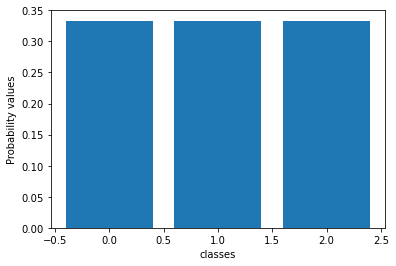


Probability Graph at split  petal_length <= 4.95
Probability at the split  [0.5 0.5]


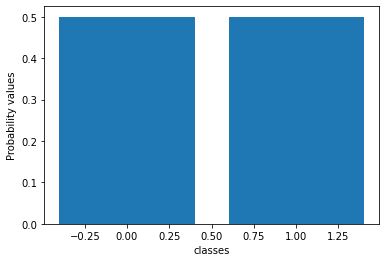


Probability Graph at split  petal_width <= 1.65
Probability at the split  [0.91891892 0.08108108]


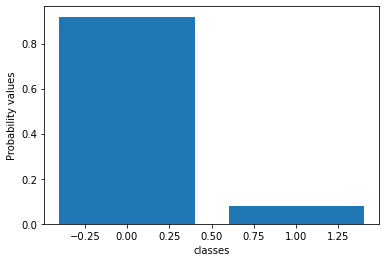


Probability Graph at split  sepal_width <= 3.0
Probability at the split  [0.25 0.75]


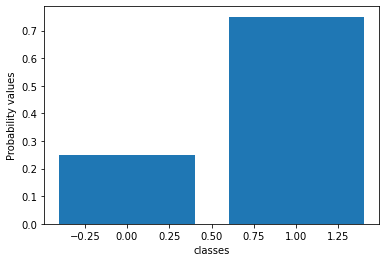


Probability Graph at split  sepal_length <= 6.05
Probability at the split  [0.03030303 0.96969697]


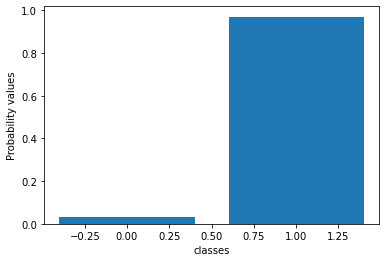


Probability Graph at split  sepal_length <= 5.9
Probability at the split  [0.33333333 0.66666667]


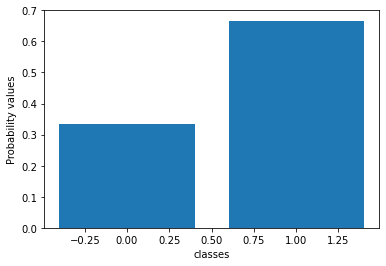

In [50]:
tree1 = decisiontree(train_df)

We observe that the probabilities of the classes differ at each decision split

In [51]:
print("The decision tree implementation using MCR criteria-\n", tree1)

The decision tree implementation using MCR criteria-
 {'petal_length <= 2.45': [0.0, {'petal_length <= 4.95': [{'petal_width <= 1.65': [1.0, {'sepal_width <= 3.0': [2.0, 1.0]}]}, {'sepal_length <= 6.05': [{'sepal_length <= 5.9': [2.0, 1.0]}, 2.0]}]}]}


In [52]:
info_gain_list=[]
split_list = []
def dtree_info_gain(df ,counter=0):
   #Decision tree implementation using information gain as quality criteria 
   # Code similar to that done above
    
    max_depth = 5
    if counter == 0:
        data = df.values
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
    else:
        data = df           
    
    
    # base cases
    if check_leaf_node(data):
        main_class = total_classes(data)
        return main_class

    
    # recursive part
    else:   
        #while(counter <= max_depth):
            counter += 1

         
            possible_splits = get_splits(data) #to get possible splits for the data given
            
            #Finding the best split according to the quality criteria information gain
            
            split_column, split_value, info_gain = determine_best_split(data, possible_splits, 'info_gain')
            
            #Dividing the data according to the best split
            data_left, data_right = split_data(data, split_column, split_value)

            # creating the tree
            feature_name = COLUMN_HEADERS[split_column]
            split = "{} <= {}".format(feature_name, split_value)
            
            
            split_list.append(counter)
            info_gain_list.append(info_gain)

            info_tree = {split: []}
            yes_tree = dtree_info_gain(data_left, counter)
            no_tree = dtree_info_gain(data_right, counter)
            
            info_tree[split].append(yes_tree)
            info_tree[split].append(no_tree)
        
            return info_tree

In [53]:
#creating tree with quality as info gain
tree2 = dtree_info_gain(train_df)

{'petal_length <= 2.45': [0.0, {'petal_length <= 4.95': [{'petal_width <= 1.65': [1.0, {'sepal_width <= 3.0': [2.0, 1.0]}]}, {'sepal_length <= 6.05': [{'sepal_length <= 5.9': [2.0, 1.0]}, 2.0]}]}]}

Plotting Information gain at each split-


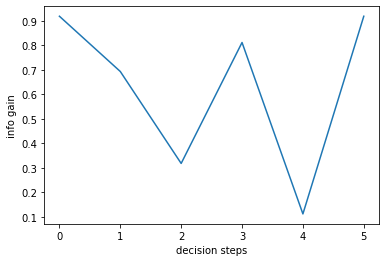

In [54]:



print(tree2)

x = np.arange(len(info_gain_list))
print("\nPlotting Information gain at each split-")
plt.xlabel("decision steps")
plt.ylabel("info gain")

plt.xticks(fontsize=10)
plt.plot(x,info_gain_list)


We observe that the information gain fluctuates between 0 and 1

In [55]:
def predict_y(X, tree):
    #To make y value predictions given the x values and the tree
    if not isinstance(tree, dict):
        return tree
    
    split_ques = list(tree.keys())[0] #to get the split questions from the tree
    feature_name, condition_operator, value = split_ques.split(" ") # getting the split col, split value and split condition

    
    if condition_operator == "<=":    
        if X[feature_name] <= float(value):
            answer = tree[split_ques][0] #if cond is satisfied then left data else right data
        else:
            answer = tree[split_ques][1] 
    
    
    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part - calling till we get y value
    else:
        remaining_tree = answer
        return predict_y(X, remaining_tree)

In [56]:
def y_predictions(df, tree):
    #To compute predictions for the given x values using the already created tree
    if len(df) != 0:
        y_pred = df.apply(predict_y, args=(tree,), axis=1) #to apply function for each row
    else:
        y_pred = pd.Series()
        
    return y_pred

In [57]:
#Finding y values from validation set using the trees constructed

y_pred_mcr = y_predictions(val_df,tree1) #predicting y using tree with mcr criteria
y_pred_infogain = y_predictions(val_df,tree2) #predicting y using tree with info gain criteria

In [58]:
y_pred_mcr

31     0.0
21     0.0
47     0.0
44     0.0
49     0.0
30     0.0
32     0.0
86     1.0
78     1.0
87     1.0
96     1.0
57     1.0
51     1.0
95     1.0
110    2.0
149    2.0
138    2.0
145    2.0
115    2.0
143    2.0
144    2.0
dtype: float64

In [59]:
val_df

,sepal_length,sepal_width,petal_length,petal_width,species
31,5.4,3.4,1.5,0.4,0
21,5.1,3.7,1.5,0.4,0
47,4.6,3.2,1.4,0.2,0
44,5.1,3.8,1.9,0.4,0
49,5.0,3.3,1.4,0.2,0
30,4.8,3.1,1.6,0.2,0
32,5.2,4.1,1.5,0.1,0
86,6.7,3.1,4.7,1.5,1
78,6.0,2.9,4.5,1.5,1
87,6.3,2.3,4.4,1.3,1


In [60]:
y_pred_infogain

31     0.0
21     0.0
47     0.0
44     0.0
49     0.0
30     0.0
32     0.0
86     1.0
78     1.0
87     1.0
96     1.0
57     1.0
51     1.0
95     1.0
110    2.0
149    2.0
138    2.0
145    2.0
115    2.0
143    2.0
144    2.0
dtype: float64

In [66]:
print(len(y_pred_infogain))
print(len(val_df))
y_val = val_df["species"]
error_info = mean_squared_error(y_pred_infogain,y_val )
error_mcr = mean_squared_error(y_pred_mcr, y_val)

print("Error on validation set with mcr criteria " ,error_mcr)
print("Error on validation set with information gain criteria ", error_info)

21
21
Error on validation set with mcr criteria  0.0
Error on validation set with information gain criteria  0.0


We observe that the y values are same using both tree . Thus error is same for both sets. 

While trying to tune the max_depth encountered Nan values in the prediction. Hence commented out that part. And also since using this code I was not able to find  the probabilities of each leaf node, hence the code for entropy loss is also removed. I took the reference for the tree implementation from the code given for ML exercise.

## Exercise 2: Gradient Boosted Decision Trees

In [28]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import math


Creating an array with 10 noise levels

In [29]:
noise_level = [0.01,0.02,0.03,0.05,0.06,0.07,0.08,0.09,0.10,0.20]
x_total=[]
y_total = []
for i in noise_level :
    x,y = make_moons(n_samples=100, shuffle=True, noise=i, random_state=None) # getting 10 sets of data with 100 samples each
    #print(i)
    print(x)
    #print(y.shape)
    x_total.append(x) #to get total x values
    y_total.append(y) #to get total y values
    

[[ 0.43220212 -0.3057907 ]
 [ 0.1824966  -0.0539526 ]
 [ 0.52402611 -0.38820009]
 [-0.66747899  0.75130467]
 [ 0.76934935 -0.47292706]
 [ 1.73350404 -0.1901753 ]
 [ 1.00652118 -0.00593065]
 [ 1.44298506 -0.38489911]
 [ 0.32008317 -0.24582721]
 [ 0.25600042 -0.1537912 ]
 [-0.5101238   0.85547482]
 [ 0.28027374 -0.18106176]
 [ 1.037936   -0.50994438]
 [ 0.00655623  0.5041846 ]
 [ 0.30265996  0.97352555]
 [-0.10203749  1.02425144]
 [ 1.5217641  -0.37329883]
 [ 0.72265331 -0.44763276]
 [ 1.99247124  0.37045417]
 [ 1.96798201  0.25320395]
 [ 1.62393171 -0.27053944]
 [-0.93874252  0.40592057]
 [-0.61180116  0.78160308]
 [-0.81365084  0.59203442]
 [ 1.98652805  0.43556282]
 [ 0.02949184  1.01539328]
 [ 0.03886305  0.2597134 ]
 [ 0.76562673  0.64730995]
 [ 1.83240321 -0.05590027]
 [ 0.93690471  0.37025501]
 [ 0.82783044  0.54460114]
 [-0.96990078  0.26129504]
 [-0.75784486  0.64576659]
 [ 0.97057033  0.25845009]
 [ 0.38803221 -0.29839444]
 [ 0.98765871  0.13436716]
 [ 0.0480128   0.18672402]
 

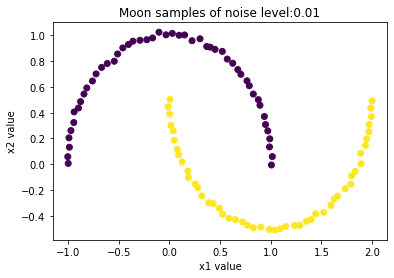

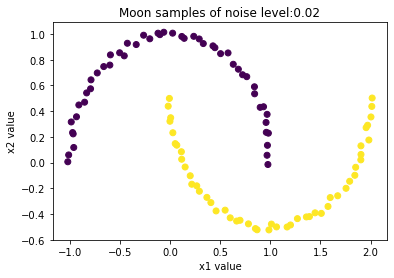

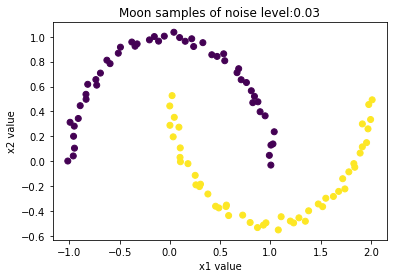

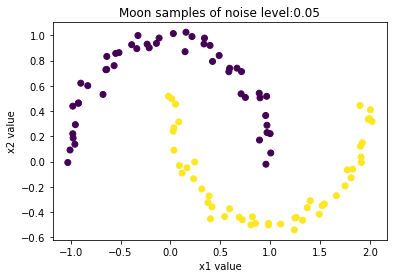

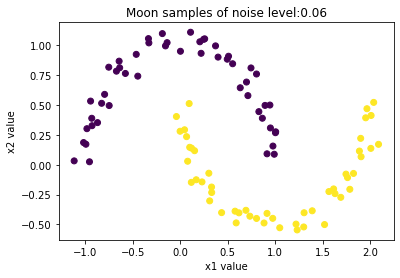

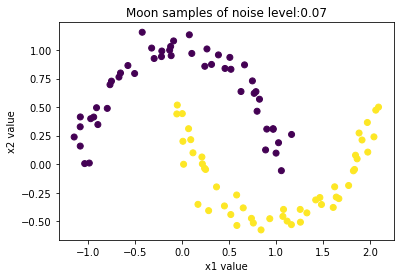

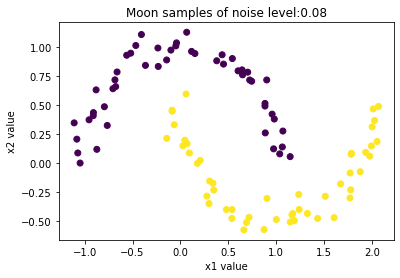

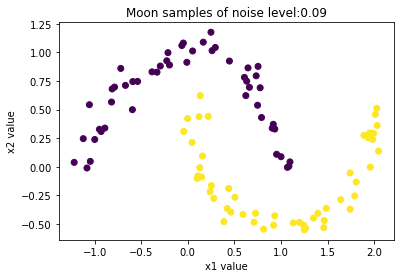

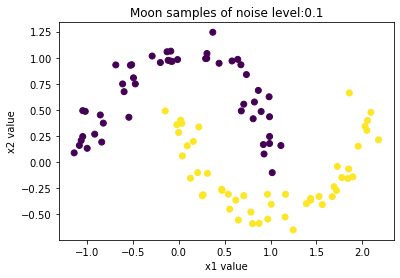

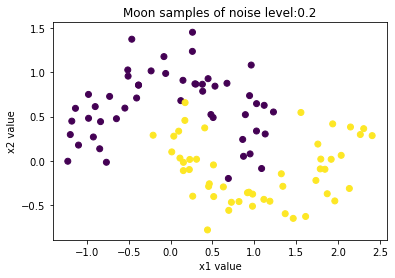

In [30]:
#Visualizing the 10 sets of x values and y values - it forms the shape of 2 half moons

for i in range(len(x_total)):
    plt.title("Moon samples of noise level:{}".format(noise_level[i]))
    x1 = x_total[i]
    
    plt.scatter(x1[:,0], x1[:,1], c=y_total[i],)
    plt.xlabel("x1 value")
    plt.ylabel("x2 value")
    
    plt.show()



In [31]:
x_total = np.array(x_total).reshape(-1,2) #concatenating all elts to one array
y_total = np.array(y_total).reshape(-1)
x_total.shape
y_total.shape

(1000,)

In [32]:
#Splitting the sets according to the ration 70:15:15

X_train, X_test, y_train, y_test = train_test_split(x_total,y_total, test_size=0.15, random_state=3116)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=3116) 


In [33]:
X_train.shape
X_train

array([[ 0.26541907, -0.31242601],
       [ 1.95694707, -0.00315258],
       [ 0.94783116,  0.36456824],
       ...,
       [ 1.99412865,  0.33962982],
       [-0.95460265,  0.37149214],
       [-0.7926136 ,  0.48877444]])

In [34]:
X_val.shape

(150, 2)

In [35]:
X_test.shape

(150, 2)

In [36]:
max_depth = 2 # given in question

In [37]:
#similar to code above
def entropy_func(c, n):
    #return entropy of given data
    return -(c*1.0/n)*math.log(c*1.0/n, 2)

def entropy_cal(c1, c2):
    #returns overall entropy
    if c1== 0 or c2 == 0:  # when there is only one class in the group, entropy is 0 (pure)
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

def entropy(data): 
    
    s = 0
    n = len(data)
    classes = set(data)
    for c in classes:   # for each class, get entropy
        n_c = sum(data==c)
        e = n_c*1.0/n * entropy_cal(sum(data==c), sum(data!=c)) # to get entropy of each class
        s += e
    return s, n


# The whole entropy 
def get_entropy(y_predict, y_real):
    #returns the entropy of a split
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy
    return s

In [38]:
#class to implement decision tree - similar to code above
class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
    
    def fit(self, x, y, par_node={}, depth=0): #values are fitted to the tree
        if par_node is None: 
            return None
        elif len(y) == 0:
            return None
        elif self.all_same(y):
            return {'val':y[0]}
        elif depth >= self.max_depth:
            return None
        else: 
            col, split_val, entropy = self.find_best_split_of_all(x, y)    # find one split given an information gain 
            y_left = y[x[:, col] < split_val]
            y_right = y[x[:, col] >= split_val]
            par_node = {'col': X_train[col], 'index_col':col,
                        'split_val':split_val,
                       'val': np.round(np.mean(y))}
            par_node['left'] = self.fit(x[x[:, col] < split_val], y_left, {}, depth+1)
            par_node['right'] = self.fit(x[x[:, col] >= split_val], y_right, {}, depth+1)
            self.depth += 1 
            self.trees = par_node
            return par_node
    
    def find_best_split_of_all(self, x, y): #to find the best split from all the splits
        col = None
        min_entropy = 1
        cutoff = None
        for i, c in enumerate(x.T):
            entropy, split_val_1 = self.find_best_split(c, y)
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return i, split_val_1, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col = i
                split_val = split_val_1
        return col, split_val, min_entropy
    
    def find_best_split(self, col, y): #calculating entropy for comparison
        min_entropy = 10
        n = len(y)
        for value in set(col):
            y_predict = col < value
            my_entropy = get_entropy(y_predict, y)
            if my_entropy <= min_entropy:
                min_entropy = my_entropy
            split_val = value
        return min_entropy, split_val
    
    def all_same(self, items):#checking if all elts have same class
        return all(x == items[0] for x in items)
                                           
    def predict(self, x): #To predict new y values for given x
        tree = self.trees  
        results = np.array([0]*len(x))
        for i, c in enumerate(x):
            results[i] = self._get_prediction(c)
        return results
    
    def _get_prediction(self, row):
        level = self.trees
        
        return level.get('val')#finding the correct value

In [39]:
tree = DecisionTreeClassifier(2)

In [40]:
tree

In [41]:
m = tree.fit(X_train,y_train)

In [42]:
print(m)

{'col': array([ 1.95694707, -0.00315258]), 'index_col': 1, 'split_val': 0.8645687316058178, 'val': 1.0, 'left': {'col': array([ 1.95694707, -0.00315258]), 'index_col': 1, 'split_val': 0.6559346408374507, 'val': 1.0, 'left': None, 'right': None}, 'right': {'val': 0}}


In [43]:
# To implement the gradientboosting algorithm
class GradientBoosting():
    
    def __init__(self, no_trees, learning_rate, max_depth=2): #Initializing all values
        self.no_trees=no_trees; 
        self.learning_rate=learning_rate; 
        self.max_depth=max_depth;
        
    def fit(self, x, y):
        self.trees = []
        self.mu = y.mean()
        Mean = self.mu
        for _ in range(self.no_trees):
            tree = DecisionTreeClassifier(max_depth=self.max_depth)# calling the tree
            m = tree.fit(x, y - Mean) #Fitting the new tree with x value and y deviations
            Mean = Mean + (self.learning_rate * tree.predict(x) )# getting new mean value
            self.trees.append(tree) #Appending new tree
            
    def predict(self, x): #For predicting y values
        return self.mu + self.learning_rate * np.sum([tree.predict(x) for tree in self.trees], axis=0)
    #new y value is calculated using mean, learning rate and sum of all current y values

In [44]:
gbm_obj = GradientBoosting(5, 0.5, 2) # passing the maximum depth, lr and no of trees
gbm_obj.fit(X_train,y_train) #training according to given values

In [45]:
#predicting y values on the test set
y_pred = gbm_obj.predict(X_test)

err = mean_squared_error(y_test, y_pred) #Calculating the mse value of true y values and predicted y values
print("The mean squared error btw y values-", err)

The mean squared error btw y values- 0.2501


In [46]:
#To tune the value of number of trees - to get tree with least error
best_err = 1000
best_num = 0
for i in range(10,50,10): #for each number of trees
    new = GradientBoosting(i, 0.3, 2)
    new.fit(X_train,y_train)
    err = mean_squared_error(y_test, new.predict(X_test)) #finding the error
    if best_err >= err :
        best_err = err #calculating the best error and best number of trees
        best_num = i
        


In [47]:
print("Loss:",best_err)
print("Best number of trees:", best_num)

Loss: 0.2501
Best number of trees: 40


We observe that the error remains the same

References:

https://github.com/SebastianMantey/Decision-Tree-from-Scratch/blob/master/notebooks/decision_tree_functions.py
https://stackoverflow.com/questions/18296755/python-max-function-using-key-and-lambda-expression
https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
https://medium.com/@penggongting/implementing-decision-tree-from-scratch-in-python-c732e7c69aea
https://blog.mattbowers.dev/gradient-boosting-machine-from-scratch
https://stackoverflow.com/questions/51102205/how-to-know-the-labels-assigned-by-astypecategory-cat-codes
https://www.analyticsvidhya.com/blog/2021/03/how-to-select-best-split-in-decision-trees-using-information-gain/
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
Also - decision tree code given in exercise sheet 9 of ML lecture